In [1]:
#MLP Classifier for MNIST digit images built from scratch with Numpy

In [2]:
#Imports
import keras
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from IPython.display import clear_output

2024-10-16 13:31:50.908951: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-16 13:31:50.913878: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-16 13:31:50.928606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 13:31:50.951665: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 13:31:50.958475: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 13:31:50.976169: I tensorflow/core/platform/cpu_feature_gu

In [3]:
#First create a dummy layer class to be inherited by layers
class Layer:
    #Each layer has a forward and backward step, and possibly some initialized parameters
    #Forward takes input from previous layer and produces output
    #Backward takes gradients from next (output) layer and the input to get gradient and adjust weights/biases
    def __init__(self):
        #Dummy layer passes
        pass

    def forward(self, input):
        #Dummy layer returns input
        return input

    def backward(self, input, grad_output):
        #Dummy layer returns gradient of loss wrt output grad_output, but here we are more explicit
        #The gradient is d_loss/d_input = d_loss/d_layerOutput * d_layerOutput/d_input
        num_units = input.shape[1]
        d_layer_d_input = np.eye(num_units)

        return np.dot(grad_output, d_layer_d_input) # = d_loss / d_input via Chain Rule

In [4]:
#Now we will define the specific layers
#Starting with the activation: ReLU
class ReLU(Layer):
    def __init__(self):
        #No parameters to initialize
        pass

    def forward(self, input):
        relu = np.maximum(0, input)
        return relu

    def backward(self, input, grad_output):
        relu_grad = input > 0 #i.e., 1 if input is >0, 0 if input is <=0
        return grad_output * relu_grad #Hence, why relu can lead to vanishing gradients

In [63]:
#Now we will define the specific layers
class Sigmoid(Layer):
    def __init__(self):
        #No parameters to initialize
        pass

    def forward(self, input):
        sigmoid = 1/(1 + np.exp(-input)) 
        return sigmoid

    def backward(self, input, grad_output):
        sigmoid_grad = np.exp(-input)/(1 + np.exp(-input))**2 
        return grad_output * sigmoid_grad 

In [5]:
#Next, the Dense layer
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate

        #Initializing weights using "Xavier Initialization"
        self.weights = np.random.normal(loc=0.0, scale=np.sqrt(2/(input_units+output_units)), 
                                        size=(input_units, output_units))

        #Initializing biases to 0
        self.biases = np.zeros(output_units)
        return

    def forward(self, input):
        #f(x) = W*x + b
        return np.dot(input, self.weights) + self.biases

    def backward(self, input, grad_output):
        #Here d_layer/d_input is the weights (transposed)
        grad_input = np.dot(grad_output, self.weights.T) #Becomes grad_output for previous layer

        #Also get gradients WRT weights and biases to make adjustments
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]

        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

        #SGD adjustments to weights and biases
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases

        return grad_input

In [6]:
#Here I define the loss function, Log-Softmax, 
#    which combines the softmax activation with cross-entropy loss
def softmax_crossentropy(logits, reference_answers):
    #Cross entropy from logits[batch_size, n_classes] and correct answers
    #Here, logits are the output of last hidden layer that get input here
    logits_for_answers = logits[np.arange(len(logits)), reference_answers]

    xentropy = -logits_for_answers + np.log(np.sum(np.exp(logits), axis=-1))

    return xentropy

#And the gradient of the loss function
def grad_softmax_crossentropy(logits, reference_answers):
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)), reference_answers] = 1

    softmax = np.exp(logits) / (np.exp(logits).sum(axis=-1, keepdims=True)) #derivative of log(x) includes x
    
    return (-ones_for_answers * softmax) / logits.shape[0]

In [7]:
#Layers and loss are defined, lets load some data
def load_data(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    #Normalize inputs
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.
    
    #Reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    
    if flatten: #Each input goes from MxN image to M*N length array for input
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])
        
    return X_train, y_train, X_val, y_val, X_test, y_test
    
X_train, y_train, X_val, y_val, X_test, y_test = load_data(flatten=True)

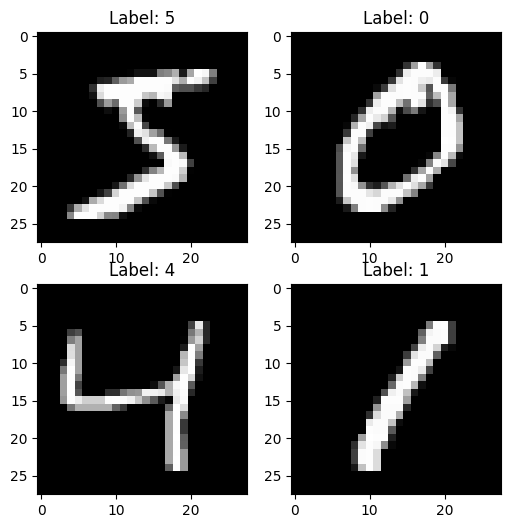

In [8]:
#Visualize!
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray')
plt.show()

In [71]:
#Build Model
network = []
network.append(Dense(X_train.shape[1],100, learning_rate=0.0001))
network.append(ReLU())
network.append(Dense(100,200, learning_rate=0.0001))
network.append(ReLU())
network.append(Dense(200,10, learning_rate=0.0001))

def forward(network, input):
    #Compute activations for layers sequentially
    activations = []

    #Loop through layers:
    for l in network:
        activations.append(l.forward(input))

        #Update input to be output of this layer
        input = activations[-1]

    assert len(activations) == len(network)

    return activations

def predict(network, input):
    #Make predictions
    logits = forward(network, input)[-1]

    #Return the indices of highest logit
    return np.argmax(logits, axis=-1)

def train(network, input, labels):
    #Train model with forward and backward propagations
    layer_activations = forward(network, input)
    layer_inputs = [input] + layer_activations
    logits = layer_activations[-1]
    
    #Get loss and first gradient
    loss = softmax_crossentropy(logits, labels)
    loss_grad = grad_softmax_crossentropy(logits, labels)

    #Backpropagation
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad)

    return np.mean(loss)

Epoch 1
Train accuracy: 0.13768
Val accuracy: 0.1331


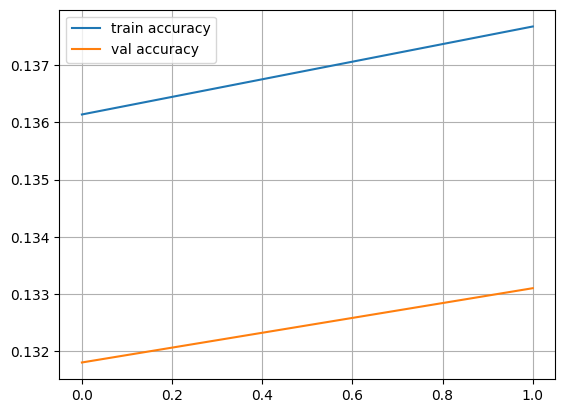

 47%|███████████████████████████████████████████████████████████████████████                                                                                 | 365/781 [00:01<00:02, 188.84it/s]


KeyboardInterrupt: 

In [72]:
#Create and iterate through mini-batches
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    
    if shuffle:
        indices = np.random.permutation(len(inputs))
        
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
            
        yield inputs[excerpt], targets[excerpt]

#Keep track of prediction accuracy
train_log = []
val_log = []
for epoch in range(100):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=64,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
        
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [ ]:
#With this simple model, at larger learning rates a local minimum is reached. 